In [243]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.preprocessing.text import Tokenizer

In [346]:
# load the dataset
import csv

with open('Corona_NLP_train.csv', encoding='latin-1',mode='r') as file:
    data = csv.DictReader(file)
    data = [row for row in data]

In [347]:
#Convert data to DataFrame
df_train = pd.DataFrame(data)
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [348]:
# Remove unwanted columns
df_train.drop(["UserName","ScreenName","TweetAt","Location"], axis=1, inplace=True)

In [349]:
df_train.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [350]:
df_train["Sentiment"].value_counts()

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [351]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


In [434]:
def preprocess_text(words):
    #Convert to lowercase
    words = words.lower()

    #initialize Stopwords
    stop_words = set(stopwords.words('english'))

    #Lemmatization
    lemmatizer = nltk.WordNetLemmatizer()
    processed_words = []
    for word in words.split():
        if word not in stop_words:
            lemmatized_word = lemmatizer.lemmatize(word)
            processed_words.append(lemmatized_word)

    processed_words = ' '.join(processed_words)

    return processed_words

In [436]:
#Preprocess text
df_train["PreprocessedTweet"] = df_train["OriginalTweet"].map(lambda x: preprocess_text(x))

In [437]:
df_train.head()

,OriginalTweet,Sentiment,PreprocessedTweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,@menyrbie @phil_gahan @chrisitv https://t.co/i...
1,advice Talk to your neighbours family to excha...,Positive,advice talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths to give elde...,Positive,"coronavirus australia: woolworth give elderly,..."
3,My food stock is not the only one which is emp...,Positive,"food stock one empty... please, panic, enough ..."
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"me, ready go supermarket #covid19 outbreak. pa..."


In [438]:
#max length of the tweet
tokens = df_train["PreprocessedTweet"].apply(lambda x: len(x.split()))
max_len = max(tokens)
max_len

59

In [439]:
# Vectorization
tf_idf_vectorizer = TfidfVectorizer(max_features=200, ngram_range=(1,3))
X = tf_idf_vectorizer.fit_transform(df_train["PreprocessedTweet"])
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 372123 stored elements and shape (41157, 200)>

In [440]:
# encoding the target variable
y = df_train["Sentiment"]

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y = encoder.fit_transform(y.values.reshape(-1,1)).toarray()
y

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]], shape=(41157, 5))

In [441]:
## Scaling the features
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_resampled, y_resampled

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 549849 stored elements and shape (57110, 200)>,
 array([[0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        ...,
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]], shape=(57110, 5)))

In [442]:
#Model Building

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(tf_idf_vectorizer.max_features,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

e:\JobSwitch_Practice\Practice Notebooks\CoronaVirusTweetsNLP\venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,309 (134.02 KB)

 Trainable params: 34,309 (134.02 KB)

 Non-trainable params: 0 (0.00 B)

In [443]:
#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'],)

In [444]:
history = model.fit(X_resampled,y_resampled,epochs=150,batch_size=50, validation_split=0)

Epoch 1/150
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4267 - loss: 1.3459
Epoch 2/150
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4746 - loss: 1.2684
Epoch 3/150
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5038 - loss: 1.2139
Epoch 4/150
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5329 - loss: 1.1584
Epoch 5/150
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5552 - loss: 1.1076
Epoch 6/150
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5756 - loss: 1.0667
Epoch 7/150
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5931 - loss: 1.0285
Epoch 8/150
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6074 - loss: 0.9961
Epoch 9/150
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6211 - loss: 0.9678
Epoch 10/150
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6287 - loss: 0.9431
Epoch 11/150
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6390 - loss: 0.9199
Epoch 12/150
1143/1

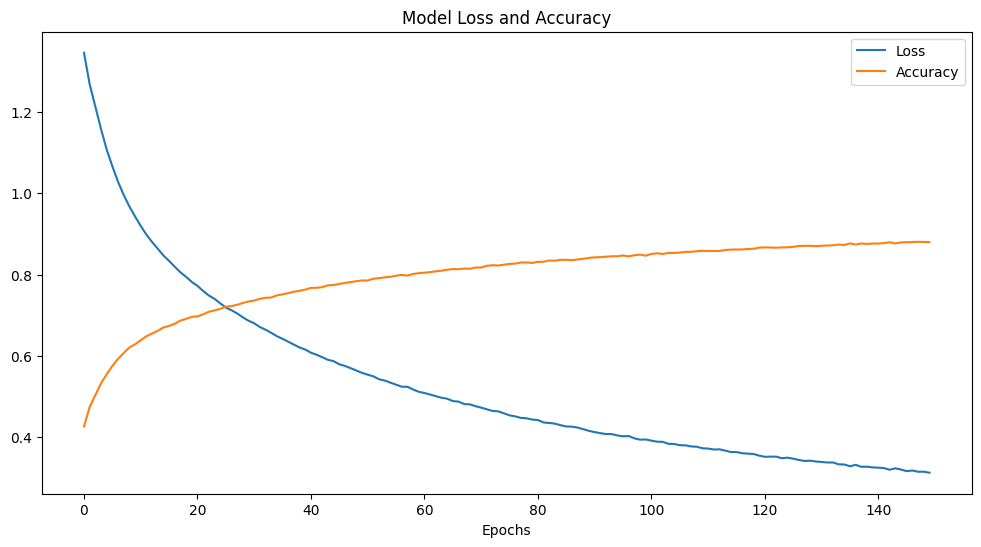

In [445]:
#Plot model accuracy comparison graph
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('Model Loss and Accuracy')
plt.xlabel('Epochs')
plt.legend(['Loss', 'Accuracy'])
plt.show()

In [446]:
#Load test data
df_test = pd.read_csv('Corona_NLP_test.csv', encoding='latin-1')
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [447]:
y_test = df_test["Sentiment"]
X_test = df_test.drop(["UserName","ScreenName","TweetAt","Location","Sentiment"], axis=1)

In [448]:
X_test

,OriginalTweet
0,TRENDING: New Yorkers encounter empty supermar...
1,When I couldn't find hand sanitizer at Fred Me...
2,Find out how you can protect yourself and love...
3,#Panic buying hits #NewYork City as anxious sh...
4,#toiletpaper #dunnypaper #coronavirus #coronav...
...,...
3793,Meanwhile In A Supermarket in Israel -- People...
3794,Did you panic buy a lot of non-perishable item...
3795,Asst Prof of Economics @cconces was on @NBCPhi...
3796,Gov need to do somethings instead of biar je r...


In [449]:
model.input_shape

(None, 200)

In [450]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

def evaluate_model(y_true,y_pred):
    print("Accuracy Score:")
    print(accuracy_score(y_true, y_pred))
    print("Mean Squared Error:")
    print(mean_squared_error(y_true, y_pred))
       

In [451]:
y_test.shape

(3798,)

In [452]:
#Encoding the target variable
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test).reshape(-1,1)
print(y_test_encoded.shape)

(3798, 1)


In [453]:
from sklearn.metrics import r2_score, mean_squared_error

# Evaluate Model
preprocessed_text = X_test["OriginalTweet"].apply(lambda x: preprocess_text(x))
vectorized_text = tf_idf_vectorizer.fit_transform(preprocessed_text)
vectorized_text = vectorized_text.toarray()
print(vectorized_text,vectorized_text.shape,type(vectorized_text))
y_pred_model1 = model.predict(vectorized_text)
y_pred_model1_labels = np.argmax(y_pred_model1, axis=1)
print(y_test_encoded.ravel().shape,y_pred_model1_labels.shape,y_test_encoded)
evaluate_model(y_test_encoded.ravel(), y_pred_model1_labels)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.40859037 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.27416988 0.         0.         ... 0.         0.         0.        ]] (3798, 200) <class 'numpy.ndarray'>
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(3798,) (3798,) [[0]
 [4]
 [1]
 ...
 [3]
 [0]
 [1]]
Accuracy Score:
0.21695629278567669
Mean Squared Error:
3.963665086887836


In [454]:
vectorized_text.size

759600

In [456]:
def predict_sentiment(model, tf_idf_vectorizer, text,encoder):
    preprocessed_text = pd.Series(data=[preprocess_text(text)])
    vectorized_text = tf_idf_vectorizer.fit_transform(preprocessed_text).toarray()
    print(vectorized_text,vectorized_text.size,vectorized_text.__sizeof__(),type(vectorized_text))
    # Pad the array with zeros to match the target size
    padded_arr = np.pad(vectorized_text.flatten(), (0, 759600 - vectorized_text.size), mode='constant')

    # Reshape
    reshaped_arr = padded_arr.reshape(3798, 200)
    print(vectorized_text, vectorized_text.shape,type(vectorized_text))
    prediction = model.predict(reshaped_arr)
    predicted_label = encoder.inverse_transform(prediction)

    return predicted_label[0][0]

In [457]:
#Sentiment Prediction
text = "Find out how you can protect yourself and loved ones from #coronavirus. ?"
print(type(preprocess_text(text)))
predicted_sentiment = predict_sentiment(model, tf_idf_vectorizer, text, encoder)
print(f"Predicted Sentiment for '{text}': {predicted_sentiment}")

<class 'str'>
[[0.28867513 0.28867513 0.28867513 0.28867513 0.28867513 0.28867513
  0.28867513 0.28867513 0.28867513 0.28867513 0.28867513 0.28867513]] 12 224 <class 'numpy.ndarray'>
[[0.28867513 0.28867513 0.28867513 0.28867513 0.28867513 0.28867513
  0.28867513 0.28867513 0.28867513 0.28867513 0.28867513 0.28867513]] (1, 12) <class 'numpy.ndarray'>
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predicted Sentiment for 'Find out how you can protect yourself and loved ones from #coronavirus. ?': Positive


In [460]:
tf_idf_vectorizer.get_feature_names_out()

array(['coronavirus', 'find', 'find protect', 'find protect loved',
       'loved', 'loved one', 'loved one coronavirus', 'one',
       'one coronavirus', 'protect', 'protect loved', 'protect loved one'],
      dtype=object)

In [461]:
model.save('corona_sentiment_model.h5')

In [462]:
import pickle

# Save the TfidfVectorizer
with open('tf_idf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tf_idf_vectorizer, file)

# Save the LabelEncoder
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)


In [463]:
# Save the OnehotEncoder
with open('onehot_encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

In [515]:
# claassification report
from sklearn.metrics import f1_score, classification_report

print(classification_report(y_test_encoded.ravel(), y_pred_model1_labels))


              precision    recall  f1-score   support

           0       0.14      0.13      0.14       592
           1       0.18      0.33      0.23       599
           2       0.28      0.21      0.24      1041
           3       0.22      0.12      0.16       619
           4       0.25      0.27      0.26       947

    accuracy                           0.22      3798
   macro avg       0.21      0.21      0.20      3798
weighted avg       0.23      0.22      0.21      3798

